## In the below pictures the `CNN pipeline` and the architecture has been shown.

In [129]:
from PIL import Image
from torchvision import transforms
import os
os.getcwd()

'/content'

## Transfroming the image as per convenience.

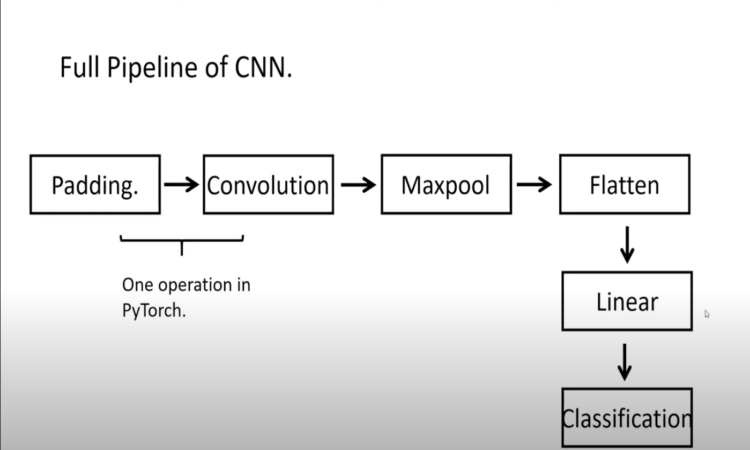

In [130]:
IM = Image.open("/content/CNN_Pipeline.jpg")
JM = Image.open("/content/CNN.jpg")
transform = transforms.Resize((450, 750))
transform(IM)



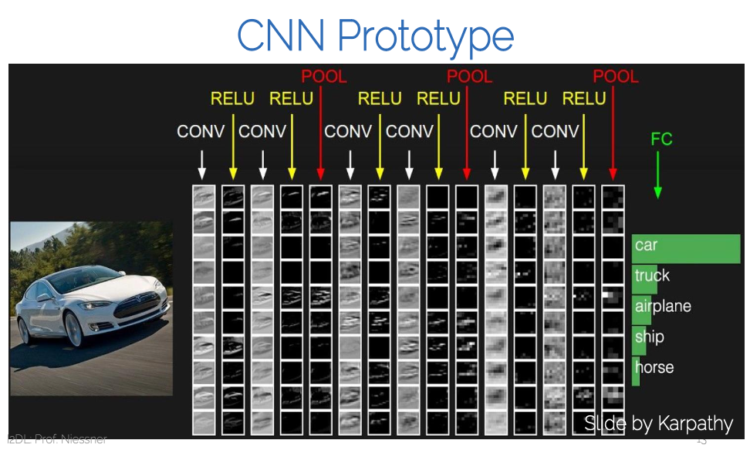

In [131]:
transform(JM)


## Mask will be the kernel size of the CNN filter. That will be sliding over the images.to extract the features.

In [179]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [180]:
mnist_dataset = datasets.MNIST(root = "./data", train = True, download = True)

In [181]:
data , target = mnist_dataset.data, mnist_dataset.targets
data.shape[0]

60000

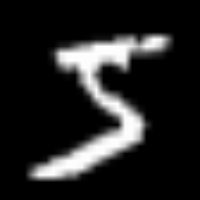

In [182]:
transform = transforms.Resize((200, 200))
transform(transforms.ToPILImage()(data[0]))

# .shape, target.shape

## From here we can see the images of the data set it is a hand written number dataset.

**This is how we have converted tensors to images**

In [183]:
# data[0].shape
# transform = transforms.Resize((200, 200))
# transform(transforms.ToPILImage()(data[0]))
# data[0].size()

In [188]:
# the purpose of using stratify is that the distribution of target variables should be balanced in training and test target data.

train_x, test_x, train_y, test_y = train_test_split(data, target, random_state = 1234, test_size = 0.2, stratify = target)
test_x.shape


torch.Size([28, 28])

In [196]:
transforms.ToPILImage()(train_x[1])
train_x[8].shape

torch.Size([28, 28])

Here as we can see that our network targets are the numbers between 0,1,2...9

In [139]:
train_y

tensor([4, 7, 7,  ..., 7, 6, 2])

## Transforms we are Normalizing with mean 0.1307, 0.3081

In [140]:
transform = transforms.Compose([
    transforms.Normalize((0.1307, ), (0.3081))

])

### Now we need the datasets and dataloader functions

In [141]:
class Dataset(torch.utils.data.Dataset):
# here we have data and terget hence we will return the item for both hence there will be two variables.
    def __init__(self,data, target, transform = None):
        self.data = data
        self.target = target
        self.transform = transform
    def __len__(self):
        return self.data.shape[0] # or here we can say len(data) instead of data.shape(0)


    def __getitem__(self, idx):
        x = self.data[idx][None, ...].float()/255 # here we are adding [None, ...] so that we can get the image
        # this mnist dataset is a data-set of black & white images so we need the size of [1,28,28]
        y = self.target[idx]
        if self.transform is not None:
            x = self.transform(x)
        return x,y

In [142]:
data.shape[0]

60000

#### AS we can see the below pic is an normalized image with given mean and variance.

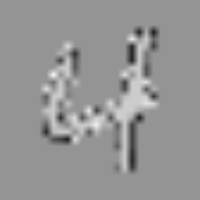

In [143]:
# checking if the Dataset class is working
Dataset(train_x, train_y, transform).__getitem__(0)[0].size()# got item of the perticuler data set instance tensor
transforms.ToPILImage()(Dataset(train_x, train_y, transform).__getitem__(0)[0]) # converted above tensor to image
# Dataset(train_x, train_y, transform).__getitem__(0) # this will give use a tensor
transform_m = transforms.Resize((200, 200))
transform_m(transforms.ToPILImage()(Dataset(train_x, train_y, transform).__getitem__(0)[0])) # this will resize and convert
# # that tensor to an Image.
# # Dataset(train_x, train_y, transform).__getitem__(0).size()


### To get the data for training the neural network we need to implement the dataloader also.

In [144]:
train_dl = torch.utils.data.DataLoader(Dataset(train_x, train_y, transform), batch_size = 16, shuffle = True,
                                       num_workers = 2)
test_dl = torch.utils.data.DataLoader(Dataset(test_x, test_y, transform), batch_size = 16, shuffle = True,
                                      num_workers = 2)

for data, target in train_dl:
  print(data.size(), target.size())
  break

torch.Size([16, 1, 28, 28]) torch.Size([16])


### Defining the number of layers and weights of the network.

In [145]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
# in the below code :: 1 -> input channels, 8 -> output channels, 3 -> kernel(filter)size, -> stride -> 1, padding -> 1

        # input image size is [20, 1 * 28 * 28] 1 -> no of channels, 28*28 is 2d image size, 20 batch size.
        self.conv1 = nn.Conv2d(1, 8, 3, stride = 1, padding =1)
        # size = 20 , 8 * 28 * 28 output image size here 8 are number of channels, 20 batch size.
        self.maxpool1 = nn.MaxPool2d(2)
        # batch size -> 20, input size -> 8 * 14 * 14
        self.relu1 = nn.ReLU()
        # output size -> 20, 8 * 14 * 14
        self.conv2 = nn.Conv2d(8, 16, 3, stride =1, padding =1)
        # output size -> 20, 16 * 14 * 14
        self.maxpool2 = nn.MaxPool2d(2) # here bydefault stride will be -> 2
        # output size -> 20, 16 * 7 * 7
        self.relu2 = nn.ReLU()
         # output size -> 20, 16 * 7 * 7
# After this we will ``flatten`` the resulting layer

        # Now we are adding fully connected layers.
        self.fc = nn.Linear(16*7*7, 10) # input is 16 *7*7 because we have 16 feature maps size of 16 * 16
        # 16*7*7, 10 here we took the output as 10 because we are looking for number betwee 0 and 10.
        # now the output is 20 * 10, 20 -> batch size , 10 -> number of outputs
#         self.SetMax()÷

# After defining all the layers we will define the forward function.

    def forward(self, input):
        output1 = self.conv1(input)
        output2 = self.maxpool1(output1)
        output3 = self.relu1(output2)
        output4 = self.conv2(output3)
        output5 = self.maxpool2(output4)
        output6 = self.relu2(output5)
        output7 = torch.flatten(output6,1)
        output8 = self.fc(output7)
        return output8


In [212]:
model = CNN()

In [213]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [214]:
num_epochs = 5
training_losses = []
test_losses = []

# we will be optimizing our model in training data set not in test data set hece as you can see here in the below code.


for epoch in range(num_epochs):
  train_epoch_loss =0
  test_epoch_loss = 0
  for data,target in train_dl:
      output = model(data)
      loss = loss_fn(output, target)
      train_epoch_loss += loss.detach().numpy()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  with torch.no_grad():
    for data, target in test_dl:
      output = model(data)
      loss = loss_fn(output, target)
      test_epoch_loss += loss.detach().numpy()
      optimizer.zero_grad()
  training_losses.append(train_epoch_loss)
  test_losses.append(test_epoch_loss)





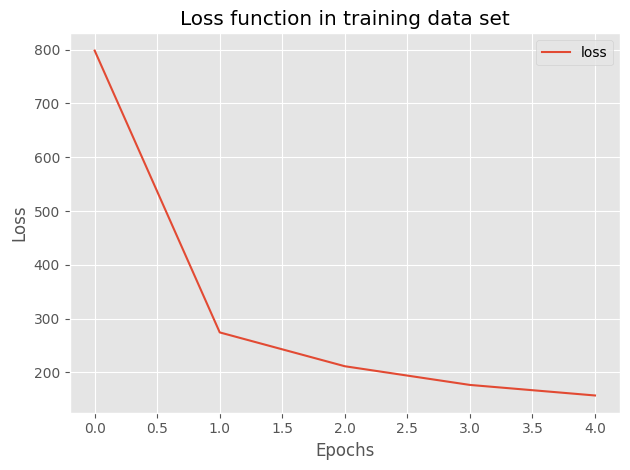

In [258]:
plt.plot(training_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["loss"])
plt.title("Loss function in training data set")
plt.tight_layout()
plt.style.use("ggplot")
plt.show()

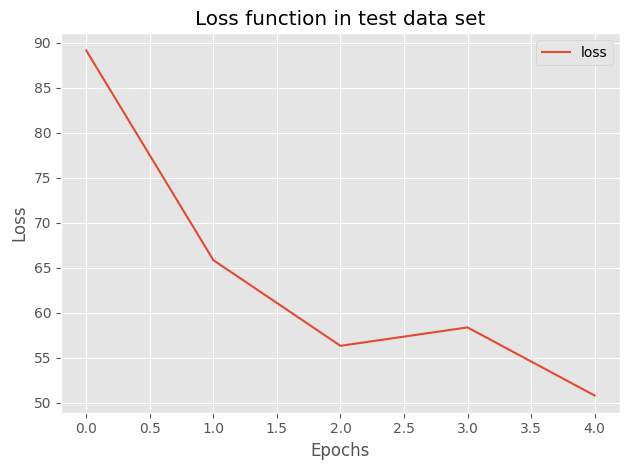

In [259]:
plt.plot(test_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["loss"])
plt.title("Loss function in test data set")
plt.tight_layout()
plt.style.use("ggplot")
plt.show()

In [250]:
for data, target in test_dl:
  data =data
  output = model(data)
  print(data[0].size())
  break

transform = transforms.Resize((200,200))



torch.Size([1, 28, 28])


## Choosing one test dataset(one image)so that we can pic one image and pass to the model and see if the model is working. This is the specifi way of choosing an appropriate number of image.

In [244]:
num = torch.randint(0,test_x.shape[0], (1, ))
num

tensor([11799])

## checking model prediction, comparing with tets dataset.

In [248]:

transform = transforms.Compose([
    transforms.Normalize((0.1307, ), (0.3081))

])
input_image  = test_x[num]
t_input_image = (input_image[None,...].float()/255)

# transform_input_image = transform(input_image)
# targ = test_y[]
# image_predicted_by_model = model(transform_input_image).argmax()

model(transform(t_input_image)).argmax(), test_y[num]

(tensor(7), tensor([7]))

### As we can see above both the model prediction and the actual train values are same.

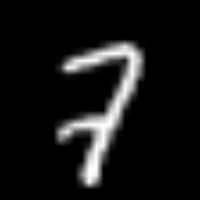

In [249]:
transform = transforms.Resize((200,200))
transform(transforms.ToPILImage()(input_image))